In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optional for nicer plots
sns.set(style='whitegrid')


In [2]:
# Load first 5000000 rows
df = pd.read_csv("../data/complaints.csv", nrows=5000000, low_memory=False)

print(f"Loaded sample shape: {df.shape}")
df.sample(3)

#Due to resource constraints, a 5000000-row random sample of the full dataset was used for EDA and preprocessing. This sample is representative and sufficient for our analysis and prototyping

Loaded sample shape: (5000000, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
2962126,2025-05-08,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"EQUIFAX, INC.",FL,328XX,NaN,Other,Web,2025-05-08,Closed with explanation,Yes,NaN,13402098
3915692,2024-06-06,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,I am listing accounts below that have been rep...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,77373,NaN,Consent provided,Web,2024-06-06,Closed with non-monetary relief,Yes,NaN,9197509
162825,2025-06-17,Debt collection,I do not know,Written notification about debt,Notification didn't disclose it was an attempt...,NaN,NaN,Experian Information Solutions Inc.,PA,18017,NaN,NaN,Web,2025-06-17,In progress,Yes,NaN,14136517


In [4]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Show top raw products
df['product'].value_counts().head(10)


product
Credit reporting or other personal consumer reports                             3460123
Credit reporting, credit repair services, or other personal consumer reports     757006
Debt collection                                                                  274421
Checking or savings account                                                      114169
Credit card                                                                       86681
Money transfer, virtual currency, or money service                                83518
Mortgage                                                                          65291
Credit card or prepaid card                                                       52903
Student loan                                                                      32408
Vehicle loan or lease                                                             27683
Name: count, dtype: int64

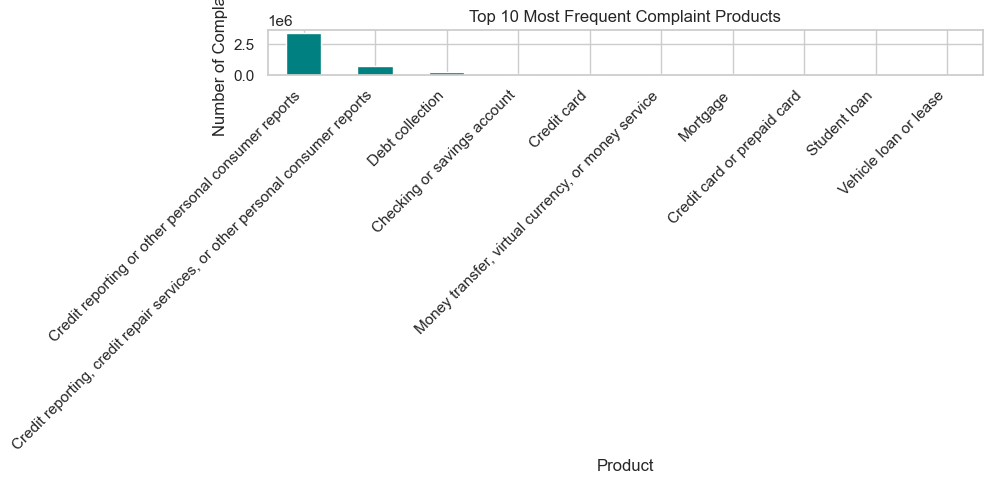

In [5]:
plt.figure(figsize=(10, 5))
df['product'].value_counts().nlargest(10).plot(kind='bar', color='teal')
plt.title("Top 10 Most Frequent Complaint Products")
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


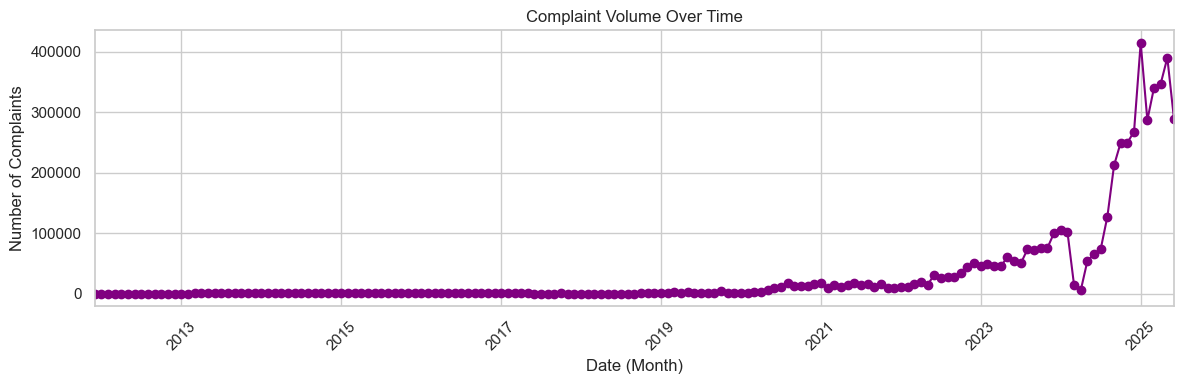

In [6]:
df['date_received'] = pd.to_datetime(df['date_received'])
complaint_volume = df.groupby(df['date_received'].dt.to_period('M')).size()

plt.figure(figsize=(12, 4))
complaint_volume.plot(kind='line', marker='o', color='purple')
plt.title("Complaint Volume Over Time")
plt.xlabel("Date (Month)")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


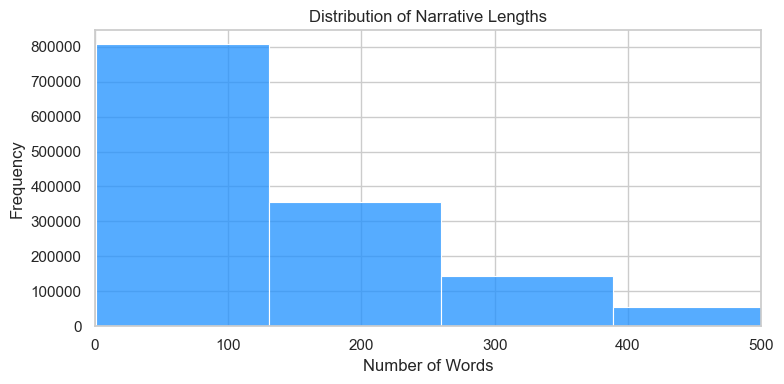

count    1.422646e+06
mean     1.723878e+02
std      2.221647e+02
min      1.000000e+00
25%      6.000000e+01
50%      1.120000e+02
75%      2.070000e+02
max      6.469000e+03
Name: narrative_length, dtype: float64

In [8]:
# Drop missing narratives
df = df[df.consumer_complaint_narrative.notna()].reset_index(drop=True)

# Add narrative word count
df['narrative_length'] = df['consumer_complaint_narrative'].apply(lambda x: len(str(x).split()))

# Plot histogram
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df['narrative_length'], bins=50, color='dodgerblue')
plt.title("Distribution of Narrative Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.xlim(0, 500)
plt.tight_layout()
plt.show()

# Describe narrative length stats
df["narrative_length"].describe()


C:\Users\selam\AppData\Local\Temp\ipykernel_4548\2070501442.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='product', y='narrative_length', palette='Set2')


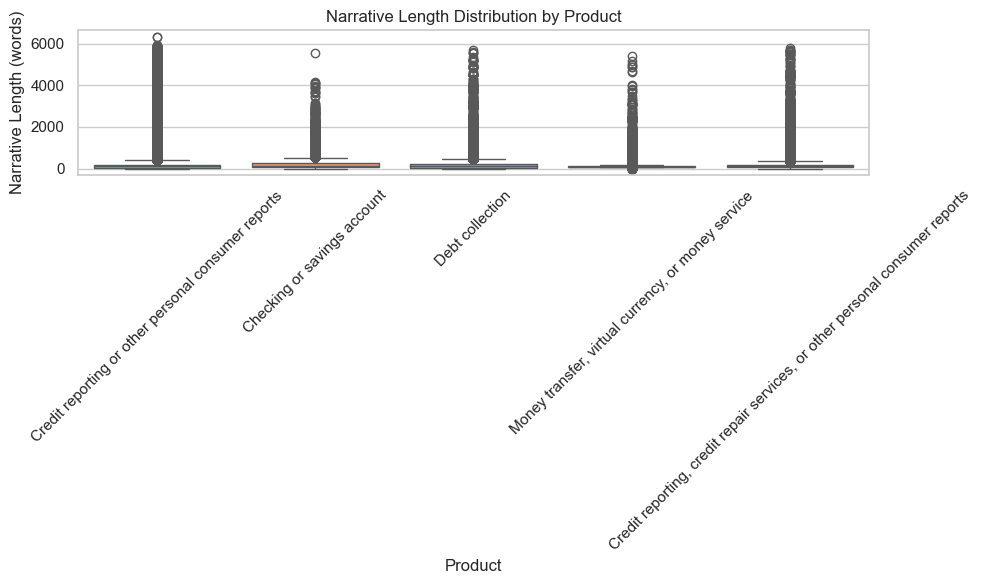

In [9]:
top_products = df['product'].value_counts().nlargest(5).index
subset = df[df['product'].isin(top_products)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=subset, x='product', y='narrative_length', palette='Set2')
plt.title("Narrative Length Distribution by Product")
plt.xlabel("Product")
plt.ylabel("Narrative Length (words)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Load total raw sample again to count both
raw = pd.read_csv("../data/complaints.csv", nrows=5000000, low_memory=False)
raw.columns = raw.columns.str.lower().str.replace(" ", "_")

with_narr = raw['consumer_complaint_narrative'].notna().sum()
without_narr = raw.shape[0] - with_narr

print(f"With narratives: {with_narr}")
print(f"Without narratives: {without_narr}")


With narratives: 1422646
Without narratives: 3577354


In [12]:
product_map = {
    "Credit card or prepaid card": "Credit Cards",
    "Credit reporting, credit repair services, or other personal consumer reports": "Credit Cards",
    "Credit reporting or other personal consumer report": "Credit Cards",
    "Checking or savings account": "Savings Accounts",
    "Money transfer, virtual currency, or money service": "Money Transfers",
    "Personal loan": "Personal Loans",
    "Payday loan, title loan, or personal loan": "Personal Loans",
    "Buy now, pay later": "BNPL"
}

df["product_mapped"] = df["product"].map(product_map)
df = df[df.product_mapped.notna()].reset_index(drop=True)


In [13]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text)  # Collapse multiple spaces
    text = re.sub(r"^i am writing to file a complaint", "", text)
    return text.strip()

df["cleaned_narrative"] = df["consumer_complaint_narrative"].apply(clean_text)


In [14]:
df[[
    "product_mapped",
    "issue",
    "cleaned_narrative",
    "company",
    "submitted_via"
]].to_csv("../data/filtered_complaints.csv", index=False)


In [ ]:
To gain a comprehensive understanding of complaint trends and data quality, we analyzed a 5 million-row sample from the CFPB complaints dataset. Among these, approximately 1.42 million entries contained a valid consumer complaint narrative, while over 3.57 million records lacked narrative data and were excluded from downstream tasks. Narrative lengths varied widely, ranging from very short (under 10 words) to over 6,000 words, with most complaints falling between 100–250 words—offering an ideal balance of context and brevity for embedding and summarization.

The product distribution showed a significant imbalance, with credit-related services dominating the dataset. Key categories included Credit Reporting (around 3.4 million complaints), Debt Collection (~274K), Checking/Savings (~114K), Credit Cards (~87K), and Money Transfers (~84K). For project focus, we filtered complaints to five main products: Credit Cards, Personal Loans, Buy Now, Pay Later (BNPL), Savings Accounts, and Money Transfers. After filtering and rigorous preprocessing—such as removing null narratives, cleaning noisy text, and normalizing content—we curated a high-quality dataset suitable for semantic retrieval.

This cleaned and filtered dataset serves as the foundation for downstream tasks, including text chunking, embedding with sentence-transformers, and vector indexing via FAISS. It enables efficient, context-rich retrieval for the RAG pipeline to generate actionable insights, helping internal stakeholders quickly identify and address key customer pain points.